# Hand Gestures recognition

Authors: Vladimir Gurevich & Mariia Padalko

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

import pandas as pd

BASE_PATH = '/content/drive/My Drive'
PATH_AUG = os.path.join(BASE_PATH, 'sign_aug.csv')
TRAIN_PATH = os.path.join(BASE_PATH, 'sign_mnist_train.csv')
TEST_PATH = os.path.join(BASE_PATH, 'sign_mnist_test.csv')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [8]:
# initial trainset target distribution
df.label.value_counts()

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
14    1196
3     1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

In [9]:
# gestures' meaning = letters in english alpabet
# but for some reasons no 9=j and 25=z in labels
alpabet_sign = {0: 'a',
                1: 'b',
                2: 'c',
                3: 'd', 
                4: 'e',
                5: 'f', 
                6: 'g',
                7: 'h',
                8: 'i',
                9: 'j',
                10: 'k', 
                11: 'l', 
                12: 'm',
                13: 'n', 
                14: 'o',
                15: 'p',
                16: 'q',
                17: 'r',
                18: 's',
                19: 't',
                20: 'u',
                21: 'v',
                22: 'w',
                23: 'x',
                24: 'y',
                25: 'z'}

### OK, to start let's plot some pics selected randomly

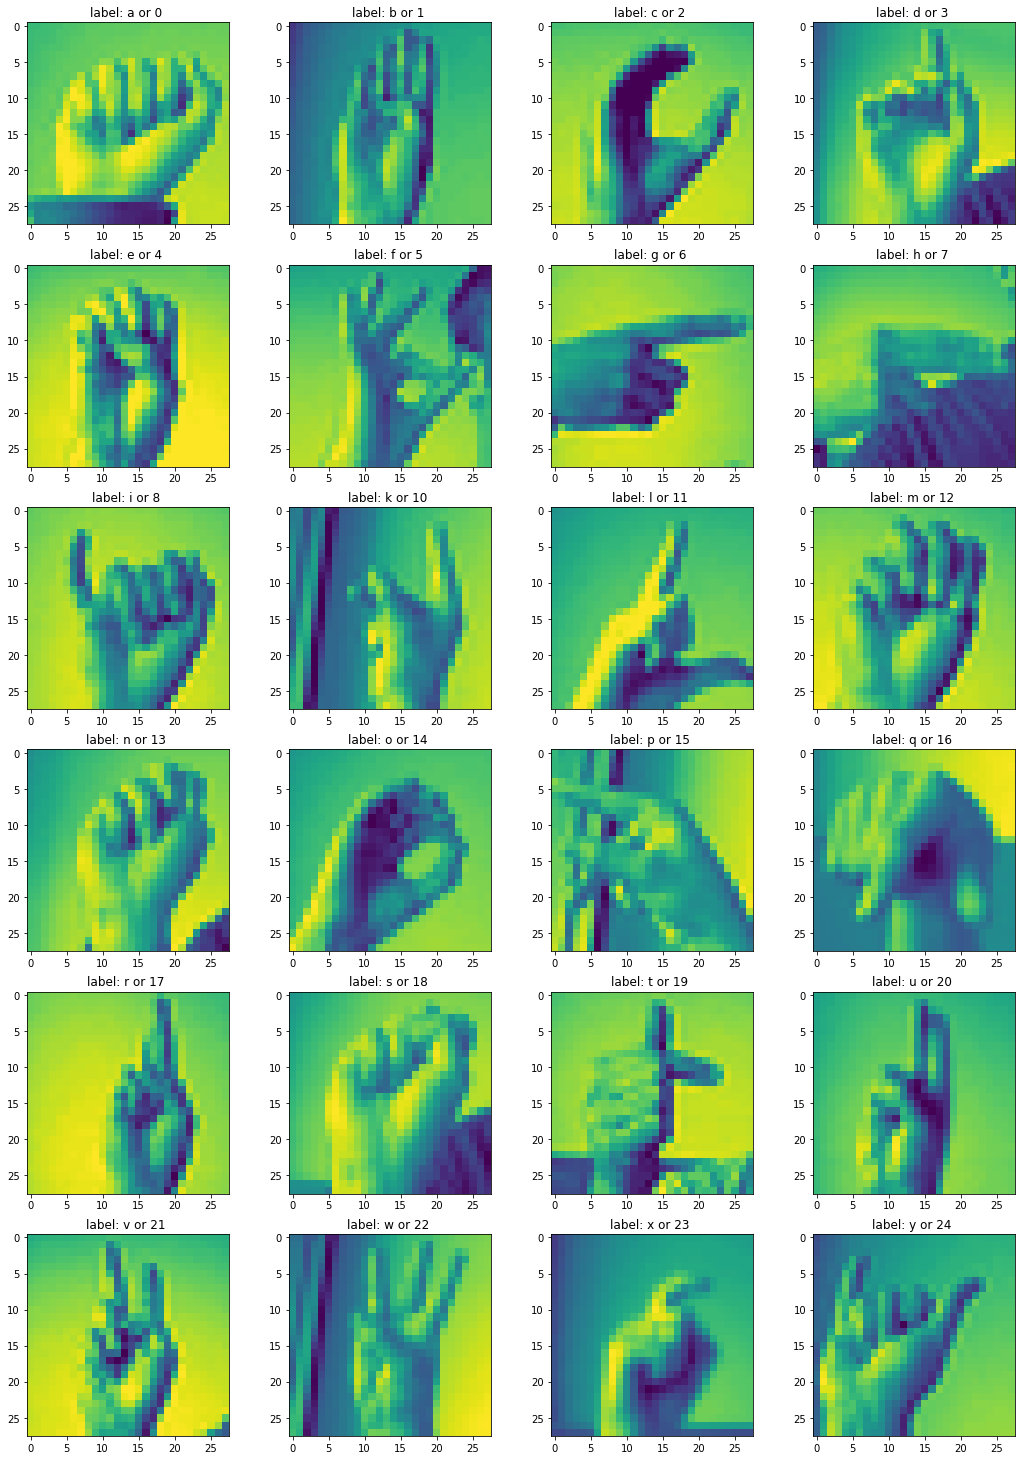

In [47]:
_, axs = plt.subplots(6, 4, figsize=(18, 26))
axs = axs.flatten()
for lab, ax in zip(np.unique(df.label), axs):
    img_array = np.array(df[df.label == lab].sample(1).iloc[:,1:]).reshape(28, 28)
    ax.imshow(img_array)
    ax.set_title(f'label: {alpabet_sign[lab]} or {lab} ')
plt.show()

In [46]:
# for i, lab in enumerate(np.unique(df.label)):
#     img_array = np.array(df[df.label == lab].sample(1).iloc[:,1:]).reshape(28, 28)
#     plt.figure(figsize=(3, 3))
#     plt.imshow(img_array)
#     plt.title(f'Assigmed label: {alpabet_sign[lab]} or {lab}')
# plt.tight_layout()

### Checking duplicates and NANs

In [ ]:
df.iloc[:,1:].duplicated().sum()

0

In [ ]:
df.isna().sum().sum()

0

Good!

### Train Test Split

In [ ]:
X_train, y_train = df.drop(columns=['label']), df.label.values 

X_test, y_test = df_test.drop(columns=['label']), df_test.label.values

### Augmenation of train set

In [ ]:
import cv2
import imutils
from skimage.transform import AffineTransform, warp

def horiz_flip_row(row):
    """
    Horizontally flips the image (this means that it flips the image with respect 
    to the vertical line)
    Args:
        row with 784 integers of pixel values of original image
    Returns:
        row with 784 pixel values of transformed image
    """
    img_array = np.array(row).reshape(28, -1)
    flipped_img = np.fliplr(img_array)
    flipped_row = pd.DataFrame(list(flipped_img.reshape(1, 784)), columns=X_train.columns)
    return flipped_row


def rotate_row(row): 
    """
    Rotates the image on some random angle between -20 and 20
    Args:
        row with 784 integers of pixel values of original image
    Returns:
        row with 784 pixel values of transformed image
    """
    img_row = np.array(row).reshape(28, 28)
    angle = np.random.randint(-10, 10)
    cv2.imwrite('gest_row_to_rotate.jpg', img_row)
    rotated_img = imutils.rotate(cv2.imread('gest_row_to_rotate.jpg'), angle)
    rotated_row = pd.DataFrame(list(rotated_img[:,:,0].reshape(1, 784)), columns=X_train.columns)
    return rotated_row


def move_vertically_row(row):
    """
    Moves image up or down a bit
    Args:
        row with 784 integers of pixel values of original image
    Returns:
        row with 784 pixel values of transformed image
    """
    shift = np.random.randint(-3, 3)
    af_trans = AffineTransform(translation=(0, shift)) 
    img_array = np.array(row).reshape(28, -1)
    shifted_img = warp(img_array, af_trans, mode='wrap')
    shifted_row = pd.DataFrame(list(shifted_img.reshape(1, 784)), columns=X_train.columns)
    return shifted_row
    
    
def move_horizontally_row(row):
    """
    Moves image left or righ a bit
    Args:
        row with 784 integers of pixel values of original image
    Returns:
        row with 784 pixel values of transformed image
    """
    shift = np.random.randint(-3, 3)
    af_trans = AffineTransform(translation=(shift, 0)) 
    img_array = np.array(row).reshape(28, -1)
    shifted_img = warp(img_array, af_trans, mode='wrap')
    shifted_row = pd.DataFrame(list(shifted_img.reshape(1, 784)), columns=X_train.columns)
    return shifted_row

def noise_row(row, noise_type='gaussian'):
    """
    Induces some random noise on the image. For now, it's only gaussian
    Other options will be added later
    Args:
        row with 784 integers of pixel values of original image
    Returns:
        row with 784 pixel values of transformed image
    """
    img_array = np.array(row).reshape(28, -1)
    if noise_type=='gaussian':
        row, col = img_array.shape
        mean, var = np.random.randint(60, 80), np.random.randint(9, 25) 
        gauss = np.random.normal(mean, np.sqrt(var), (row, col)).reshape(row, col)
        noised_img = img_array+gauss
        noised_row = pd.DataFrame(list(noised_img.reshape(1, 784)), columns=X_train.columns)
        return noised_row

def blur_row(row):
    """
    Puts gaussian blur on the image
    Args:
        row with 784 integers of pixel values of original image
    Returns:
        row with 784 pixel values of transformed image
    """
    img_array = np.array(row).reshape(28, -1)
    cv2.imwrite('ges_row_to_blur.jpg', img_array)
    blurred_img = cv2.GaussianBlur(cv2.imread('ges_row_to_blur.jpg'), (3, 3), 0)[:,:,0]
    blurred_row = pd.DataFrame(list(blurred_img.reshape(1, 784)), columns=X_train.columns)
    return blurred_row



trans_options = ['horiz_flip_row', 'rotate_row', 'move_vertically_row', 'move_horizontally_row', 
              'blur_row', 'noise_row']

def augmentate(row_index, X_train, y_train, horiz_flip=True, rotate_r=True, move_vert=False, move_hor=False, blur_r=False, noise_r=True):
    """
    Horizontally flips the image (this means that it flips the image with respect 
    to the vertical line)
    Args:
        row_index: index of row to take image and it's label from
        X_train, y_train: train data, pixel values of images and labels
        horiz_flip: boolean, defaults to True
        rotate_r: boolean, defaults to True
        move_vert: boolean, defaults to False
        move_hor:  boolean, defaults to False
        blur_r: boolean, defaults to False
        noise_r: boolean, defaults to True
    Returns:
        dataframe with pixel values for generated images
        labels for new images (same label as the label of original pic)
    """
    start_df = X_train.head(0)
    initial_row, its_label = X_train.iloc[row_index,:], y_train[row_index]
    finish_label = [its_label]*np.sum([horiz_flip, rotate_r, move_vert, move_hor, blur_r, noise_r])
    if horiz_flip:
        start_df = start_df.append(horiz_flip_row(initial_row))
    if rotate_r:
        start_df = start_df.append(rotate_row(initial_row))
    if move_vert:
        start_df = start_df.append(move_vertically_row(initial_row))
    if move_hor:
        start_df = start_df.append(move_horizontally_row(initial_row))
    if blur_r:
        start_df = start_df.append(blur_row(initial_row))
    if noise_r:
        start_df = start_df.append(noise_row(initial_row))
    return start_df, finish_label

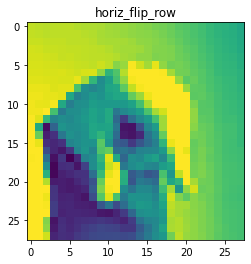

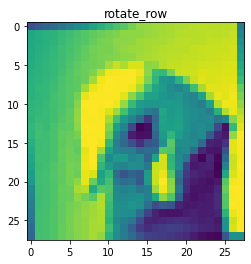

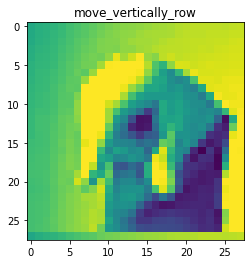

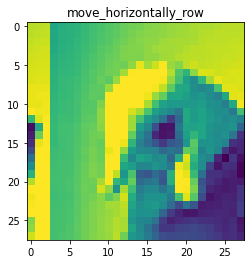

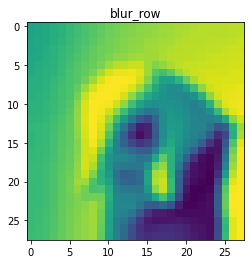

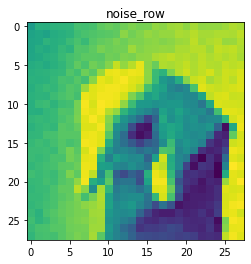

In [ ]:
# let's try to generate new images for the image in the 5th row
new_x_chunk, new_y_labels = augmentate(5, X_train, y_train, blur_r=True, move_vert=True, move_hor=True)
for i in range(len(new_x_chunk)):
    plt.figure()
    plt.imshow(np.array(new_x_chunk.iloc[i,:]).reshape(28, 28))
    plt.title(trans_options[i])

In [ ]:
import time
def augment_train(X_train, y_train, max_quantity_to_add=4500, path_to_save_aug=PATH_AUG):
    """
    Takes train set, images and labels, and generates some number of new pics of each label
    Args:
        X_train: df with pixel values
        y_train: labels
        max_quantity_to_add: maximal quantity of images of each label to be generated
        path_to_save_aug: path to save df with generated and train images together
    """

    t0 = time.time()
    start_x, start_y = X_train.head(0), list([5])
    # dict with counters, we'll make < max_quantity_to_add pics for each label
    counters_dict = {label: 0 for label in np.unique(y_train)}

    # now, let's take 1 random image out of all generated for each row until we reach max_quantity_to_add 
    # in the previous version, the whole amount of generated pics for each row was taken
    # so, we will have more variety, but the code might be slower

    for i in X_train.index.tolist(): 
        if counters_dict[y_train[i]] <= max_quantity_to_add:
            new_x_chunk, new_y_labels = augmentate(i, X_train, y_train, move_hor=True, move_vert=True)
            start_x = start_x.append(new_x_chunk) # previous
            start_y = start_y + new_y_labels # previous
            counters_dict[y_train[i]] += len(new_y_labels) # previous

    t1 = time.time()
    print(f'Generating new {len(start_x)} images took {t1-t0}s')
    start_y = start_y[1:]
    augmented_train_x = X_train.append(start_x)
    augmented_train_y = list(y_train) + start_y

    augmented_train = augmented_train_x.copy().astype('int32')
    augmented_train['label'] = pd.Series(augmented_train_y)
    for i in range(len(augmented_train)):
        augmented_train.iloc[i,-1] = augmented_train_y[i]

    # flip columns here to make it easier to work later
    cols = list(augmented_train.columns)
    cols = [cols[-1]] + cols[:-1]
    augmented_train = augmented_train[cols]

    augmented_train.to_csv(path_to_save_aug)
    return augmented_train

In [48]:
# sign_aug = augment_train(X_train, y_train)
sign_aug = pd.read_csv(PATH_AUG).drop(columns=['Unnamed: 0']) # to save a lot of time :)
sign_aug.label.value_counts()

17    5799
16    5784
11    5746
22    5730
5     5709
18    5704
3     5701
14    5701
19    5691
23    5669
8     5667
20    5666
13    5656
2     5649
0     5631
24    5623
10    5619
6     5595
15    5593
21    5587
12    5560
7     5518
1     5515
4     5462
Name: label, dtype: int64

### Time for NNS

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import argparse
from collections import OrderedDict
from xgboost import XGBClassifier

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### Deep Learning models ###
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D
#from tensorflow. keras.utils import np_utils
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import models
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import densenet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

import time

### Redefining train and test sets to feed to NN

In [4]:
# load the data
df = pd.read_csv('/content/drive/My Drive/sign_mnist_train.csv')
sign_aug = pd.read_csv(PATH_AUG).drop(columns=['Unnamed: 0'])
df_test = pd.read_csv('/content/drive/My Drive/sign_mnist_test.csv')

# get independent and targets vars
X_train, y_train = df.drop(columns=['label']), df.label.values
X_aug, y_aug = sign_aug.drop(columns=['label']), sign_aug.label.values
X_test, y_test = df_test.drop(columns=['label']), df_test.label.values

shape_x = 28
shape_y = 28

# reshape
X_train = X_train.values.reshape(-1, shape_x, shape_y, 1)
X_test = X_test.values.reshape(-1, shape_x, shape_y, 1)
X_aug = X_aug.values.reshape(-1, shape_x, shape_y, 1)

# rescale
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
X_aug = X_aug/X_aug.max()

# check out shapes
print(f'Train data has shape: {X_train.shape},augmented of shape {X_aug.shape} \
and test data is of shape: {X_test.shape}')

# define some consts
input_shape = X_train.shape[1:]
classes = np.unique(y_train)
nClasses = len(classes)
print(f'Input shape: {input_shape}, and target classes: {classes}')


Train data has shape: (27455, 28, 28, 1),augmented of shape (135575, 28, 28, 1) and test data is of shape: (7172, 28, 28, 1)
Input shape: (28, 28, 1), and target classes: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [5]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_aug = to_categorical(y_aug)

In [6]:
# plotting funcs

import numpy as np
import matplotlib.pyplot as plt


def plot_accuracy(history, title=f'accuracy for train and val'):
    plt.figure(figsize=(15,4))
    plt.plot(np.arange(1, len(history.history['accuracy'])+ 1), history.history['accuracy'],'r', label='accuracy')
    plt.plot(np.arange(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'],'b', label = 'val_accuracy')
    best_val_acc = round(max(history.history['val_accuracy']), 5)
    plt.scatter(np.argmax(list(history.history['val_accuracy']))+1, max(history.history['val_accuracy']), c='magenta',
               label=f'highest val_accuracy: {best_val_acc}')
    plt.xlabel('epoch')
    plt.ylabel('accuracy score')
    plt.ylim([0, 1])
    plt.xlim([1, len(history.history['accuracy'])+1])
    plt.title(title)
    plt.legend()
    plt.show()


def plot_loss(history, title=f'losses for train and val'):
    plt.figure(figsize=(15,4))
    plt.plot(np.arange(1, len(history.history['loss'])+ 1), history.history['loss'],'r', label='loss')
    plt.plot(np.arange(1, len(history.history['val_loss'])+1), history.history['val_loss'],'b', label = 'val_loss')
    best_val_loss = round(min(history.history['val_loss']), 5)
    plt.scatter(np.argmin(list(history.history['val_loss']))+1, min(history.history['val_loss']), c='magenta',
               label=f'lowest val_loss: {best_val_loss}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.ylim([0, 5])
    plt.xlim([1, len(history.history['loss'])+1])
    plt.title(title)
    plt.legend()
    plt.show()

### CNN @TF

In [18]:
def createcnn0():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.15))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.15))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.15))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.15))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.15))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.15))

    model.add(Dense(25)) # = y_test.shape[1]
    model.add(Activation('softmax'))
    return model


In [20]:
cnn0_sign = createcnn0()
cnn0_sign.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 32
epochs = 10

mcp_save = ModelCheckpoint('cnn0_sign.h5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, verbose=1, min_delta=1e-4, mode='max')



history_cnn0_sign = cnn0_sign.fit(
    X_aug, y_aug, 
    epochs = epochs, 
    batch_size=batch_size,
   validation_data=(X_test, y_test),
   callbacks=[mcp_save, reduce_lr_acc]) 

Epoch 1/10
4237/4237 [==============================] - 33s 8ms/step - loss: 1.2327 - accuracy: 0.6291 - val_loss: 0.2581 - val_accuracy: 0.9219
Epoch 2/10
4237/4237 [==============================] - 32s 8ms/step - loss: 1.0440 - accuracy: 0.6853 - val_loss: 0.0744 - val_accuracy: 0.9796
Epoch 3/10
4231/4237 [============================>.] - ETA: 0s - loss: 1.0321 - accuracy: 0.6888
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
4237/4237 [==============================] - 32s 8ms/step - loss: 1.0321 - accuracy: 0.6888 - val_loss: 0.0798 - val_accuracy: 0.9841
Epoch 4/10
4237/4237 [==============================] - 32s 8ms/step - loss: 1.0222 - accuracy: 0.6917 - val_loss: 0.0334 - val_accuracy: 0.9862
Epoch 5/10
4234/4237 [============================>.] - ETA: 0s - loss: 1.0221 - accuracy: 0.6917
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.
4237/4237 [==============================] - 32s 8ms/step - loss: 1.0221 - 

Ok, our test set is very simple for NN, let's use some val_split to train this NN

In [23]:
cnn0_valsplit = createcnn0()
cnn0_valsplit.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 32
epochs = 10

mcp_save = ModelCheckpoint('cnn0_valsplit.h5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, verbose=1, min_delta=1e-4, mode='max')



history_cnn0_valsplit = cnn0_valsplit.fit(
    X_aug, y_aug, 
    epochs = epochs, 
    batch_size=batch_size,
   validation_split=0.2,
   callbacks=[mcp_save, reduce_lr_acc]) 

Epoch 1/10
3390/3390 [==============================] - 29s 8ms/step - loss: 1.1922 - accuracy: 0.6422 - val_loss: 1.3263 - val_accuracy: 0.5992
Epoch 2/10
3390/3390 [==============================] - 28s 8ms/step - loss: 0.9834 - accuracy: 0.7038 - val_loss: 1.2932 - val_accuracy: 0.6059
Epoch 3/10
3385/3390 [============================>.] - ETA: 0s - loss: 0.9718 - accuracy: 0.7077
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
3390/3390 [==============================] - 28s 8ms/step - loss: 0.9717 - accuracy: 0.7078 - val_loss: 1.2789 - val_accuracy: 0.6096
Epoch 4/10
3390/3390 [==============================] - 28s 8ms/step - loss: 0.9579 - accuracy: 0.7126 - val_loss: 1.3831 - val_accuracy: 0.5721
Epoch 5/10
3390/3390 [==============================] - 29s 9ms/step - loss: 0.9583 - accuracy: 0.7121 - val_loss: 1.2787 - val_accuracy: 0.6098
Epoch 6/10
3385/3390 [============================>.] - ETA: 0s - loss: 0.9566 - accuracy: 0.7128
Epoch 0000

In [24]:
# evaluate the last cnn on test set

model_to_check = createcnn0()
# Loading weights from saved model
model_to_check.load_weights('/content/cnn0_valsplit.h5') 
model_to_check.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
# Evaluate it
loss, acc = model_to_check.evaluate(X_test, y_test, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

225/225 [==============================] - 1s 4ms/step - loss: 0.0445 - accuracy: 0.9875
Restored model, accuracy: 98.75%


### Fight with Pytorch

In [2]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=827f2d48064bd633b2a15f261aa92460f1f171d4b3e22332ffc20004c98360d7
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [7]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import random
import GPUtil
from torchsummary import summary
from torch.autograd import Variable
torch.__version__

random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_file = os.path.join(BASE_PATH, 'sig_aug_zip.zip')
test_file = os.path.join(BASE_PATH, 'sign_mnist_test_csv.zip')

In [8]:
class HandSign(torchvision.datasets.vision.VisionDataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
      super(HandSign, self).__init__('.',
                                         transform=transform,
                                         target_transform=target_transform)
      
      self.data = data
      self.labels = labels

    def __getitem__(self, idx):
      img, target = self.data[idx], self.labels[idx]
      if self.transform is not None:
        img = self.transform(img)
      if self.target_transform is not None:
        target = self.target_transform(target)
      return img, target

    def __len__(self):
        return len(self.data)

    @staticmethod
    def from_file(filename):
      df = pd.read_csv(filename, compression="zip")
      if 'Unnamed: 0' in df.columns.to_list():
          df = df.drop(columns=['Unnamed: 0'])
      labels = torch.from_numpy(df.iloc[:,0].values)
      data = torch.from_numpy(df.iloc[:,1:].values).float().view(-1,1,28,28)
      # train_x = np.array(X_train/X_train.max().values) # rescaled and nice :) -лучше это в трансформ добавить
      del df
      return HandSign(data, labels)

In [9]:
train_data = HandSign.from_file(train_file)
test_data = HandSign.from_file(test_file)

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=32, 
                                           shuffle=False,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=1, 
                                           shuffle=False,
                                           num_workers=1)

### CNN @Pytorch

In [27]:
class CNN0(torch.nn.Module): 
    def __init__(self):
        super(CNN0, self).__init__()

        self.conv1 = nn.Conv2d(1, 128, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.batchnorm1 = nn.BatchNorm2d(128)


        self.conv2 = nn.Conv2d(128, 256, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.batchnorm2 = nn.BatchNorm2d(256)

        self.conv3 = nn.Conv2d(256, 512, 3)
        self.pool3 = nn.MaxPool2d(2)
        self.batchnorm3 = nn.BatchNorm2d(512)

        self.dropout1 = nn.Dropout2d(0.15)
        self.fc3 = nn.Linear(512, 270) 

        self.fc4 = nn.Linear(270, 26)
        self.softmax = nn.LogSoftmax(dim=1)
    
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.dropout1(x)

                
        x = x.view(-1, 512) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return self.softmax(x)

modelcnn0 = CNN0().to(device)
summary(modelcnn0, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 26, 26]           1,280
       BatchNorm2d-2          [-1, 128, 26, 26]             256
         MaxPool2d-3          [-1, 128, 13, 13]               0
            Conv2d-4          [-1, 256, 11, 11]         295,168
       BatchNorm2d-5          [-1, 256, 11, 11]             512
         MaxPool2d-6            [-1, 256, 5, 5]               0
            Conv2d-7            [-1, 512, 3, 3]       1,180,160
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
         MaxPool2d-9            [-1, 512, 1, 1]               0
        Dropout2d-10            [-1, 512, 1, 1]               0
           Linear-11                  [-1, 270]         138,510
           Linear-12                   [-1, 26]           7,046
       LogSoftmax-13                   [-1, 26]               0
Total params: 1,623,956
Trainable param

In [28]:
epochs = 10
optimizer = torch.optim.SGD(modelcnn0.parameters(),0.009, momentum=0.7)   
loss_func = nn.CrossEntropyLoss()


for epoch in range(epochs):  # loop over the dataset multiple times
        
        running_loss = 0
        total_train = 0
        correct_train = 0
        for i, data in enumerate(train_loader, 0):

            # get the inputs
            t_image, mask = data
            t_image, mask = Variable(t_image.to(device)), Variable(mask.to(device))
        
            # zeroes the gradient buffers of all parameters
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = modelcnn0(t_image) # forward
            loss = loss_func(outputs, mask) # calculate the loss
            loss.backward() # back propagation
            optimizer.step() # update gradients

            running_loss += loss.item()
            
            # accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += mask.nelement()
            correct_train += predicted.eq(mask.data).sum().item()
            train_accuracy = 100 * correct_train / total_train                        
            
        print('Epoch {}, Train Loss: {:.3f}'.format(epoch, loss.item()), "Training Accuracy: %d %%" % (train_accuracy))

Epoch 0, Train Loss: 1.418 Training Accuracy: 65 %
Epoch 1, Train Loss: 1.417 Training Accuracy: 69 %
Epoch 2, Train Loss: 1.417 Training Accuracy: 69 %
Epoch 3, Train Loss: 1.417 Training Accuracy: 69 %
Epoch 4, Train Loss: 1.417 Training Accuracy: 69 %
Epoch 5, Train Loss: 1.417 Training Accuracy: 69 %
Epoch 6, Train Loss: 1.417 Training Accuracy: 69 %
Epoch 7, Train Loss: 1.417 Training Accuracy: 69 %
Epoch 8, Train Loss: 1.417 Training Accuracy: 69 %
Epoch 9, Train Loss: 1.417 Training Accuracy: 69 %


In [29]:
for epoch in range(1):  # loop over the test 
        
        running_loss = 0
        total_test = 0
        correct_test = 0
        for i, data in enumerate(test_loader, 0):
        #for img, target in train_loader:
            # get the inputs
            t_image, mask = data
            t_image, mask = Variable(t_image.to(device)), Variable(mask.to(device))
        

            # zeroes the gradient buffers of all parameters
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = modelcnn0(t_image) # forward
            loss = loss_func(outputs, mask) # calculate the loss
            loss.backward() # back propagation
            # optimizer.step() # update gradients # shit shit oi!

            # added stuff
            running_loss += loss.item()
            
            # accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += mask.nelement()
            correct_test += predicted.eq(mask.data).sum().item()
            test_accuracy = 100 * correct_test / total_test                        
            
        print('Epoch {}, Test Loss: {:.3f}'.format(epoch, loss.item()), "Test Accuracy: %d %%" % (test_accuracy))

Epoch 0, Test Loss: 0.020 Test Accuracy: 81 %


Nice! :) 

In [30]:
torch.save(modelcnn0, 'modelcnn0_pytorch_do.h5')